In [12]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

def plot_boxes(image, boxes):
    # Convert PIL image to NumPy array
    image = np.array(image)
    
    # Initialize plot
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    classes = boxes.cls

    # Define a list of colors for different classes
    cmap = plt.get_cmap("tab10")  # Colormap with 20 different colors
    unique_classes = classes.unique().tolist()
    class_to_color = {cls: cmap(i)[:3] for i, cls in enumerate(unique_classes)}
    
    # Plot each bounding box
    for i, box in enumerate(boxes):
        # Get the class and corresponding color
        cls = int(classes[i].item())
        color = class_to_color[cls]

        # Extract the coordinates from the box (xyxy format)
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        width = x2 - x1
        height = y2 - y1
        
        # Create a rectangle patch
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor=color, facecolor='none')

        # Add the rectangle to the plot
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()



In [29]:
from ultralytics import YOLO
import ultralytics.yolosam.utils as yolosam
from PIL import Image
import torch

model = YOLO("yolov8n.pt")

sam_model = yolosam.initialize_model("facebook/sam2-hiera-tiny")

image_path = "ultralytics/assets/bus.jpg" 
image = Image.open(image_path).convert("RGB") 

results = model(image_path)

new_data = []

# Process each detected box
for i, box in enumerate(results[0].boxes):
    # Get the new bounding box using sam_bbox
    new_bbox_tensor = yolosam.sam_bbox(box.xyxy, image, sam_model).to('cuda')  # Ensure tensor is on GPU
    
    # Ensure that conf and cls are correctly shaped
    conf_tensor = results[0].boxes.conf[i].unsqueeze(0).unsqueeze(1)  # Make sure it's 2D
    cls_tensor = results[0].boxes.cls[i].unsqueeze(0).unsqueeze(1)    # Make sure it's 2D

    # Convert the new bounding box tensor to be 2D
    if new_bbox_tensor.dim() == 1:
        new_bbox_tensor = new_bbox_tensor.unsqueeze(0)  # Make it 2D if necessary

    # Create a new tensor combining the new bbox with the original confidence and class
    new_data_tensor = torch.cat((new_bbox_tensor, conf_tensor, cls_tensor), dim=1)

    print(f"Before: {box.xyxy}, After: {new_bbox_tensor}")
    new_data.append(new_data_tensor)

# Concatenate all new data tensors
new_datas_tensor = torch.cat(new_data, dim=0)  # Use dim=0 to concatenate vertically

# Retrieve the original image shape
orig_shape = results[0].orig_shape

# Recreate the Boxes object with the new boxes and the original shape
new_boxes_object = results[0].boxes.__class__(new_datas_tensor, orig_shape)




image 1/1 /home/youho/yolo-sam/ultralytics/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 35.6ms
Speed: 2.0ms preprocess, 35.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)
Before: tensor([[ 22.8713, 231.2773, 805.0026, 756.8405]], device='cuda:0'), After: tensor([[ 22., 231., 802., 732.]], device='cuda:0')
Before: tensor([[ 48.5505, 398.5522, 245.3456, 902.7027]], device='cuda:0'), After: tensor([[ 48., 400., 244., 902.]], device='cuda:0')
Before: tensor([[669.4729, 392.1861, 809.7202, 877.0355]], device='cuda:0'), After: tensor([[670., 392., 809., 878.]], device='cuda:0')
Before: tensor([[221.5173, 405.7986, 344.9707, 857.5366]], device='cuda:0'), After: tensor([[225., 407., 342., 858.]], device='cuda:0')
Before: tensor([[  0.0000, 550.5250,  63.0069, 873.4429]], device='cuda:0'), After: tensor([[  0., 553.,  64., 869.]], device='cuda:0')
Before: tensor([[5.8174e-02, 2.5446e+02, 3.2557e+01, 3.2487e+02]], device='cuda:0'), After: tensor([[  0.

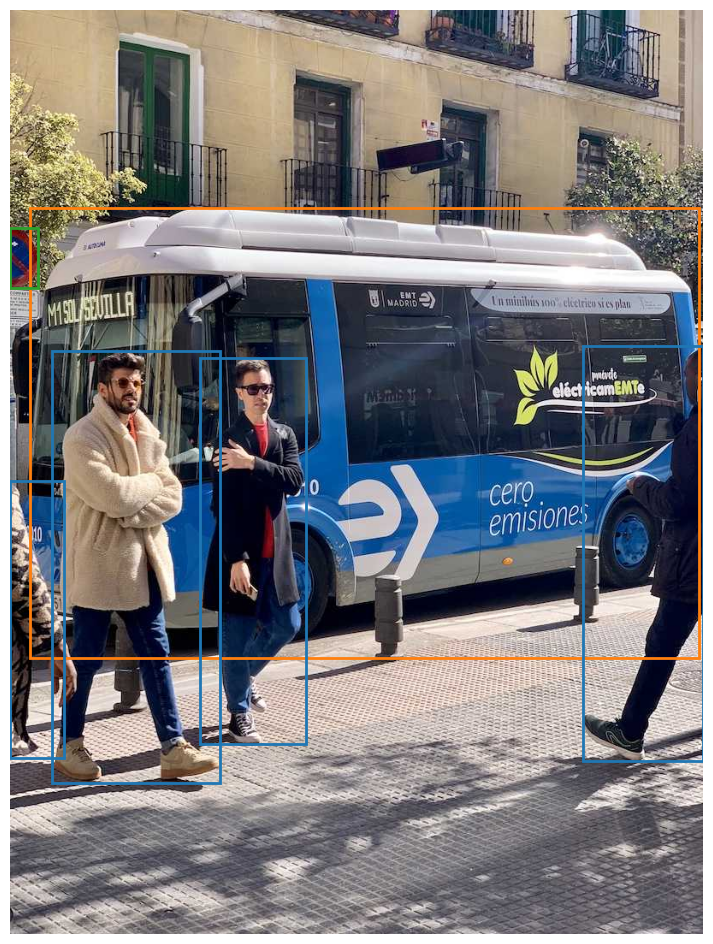

In [47]:
plot_boxes(image, results[0].boxes)

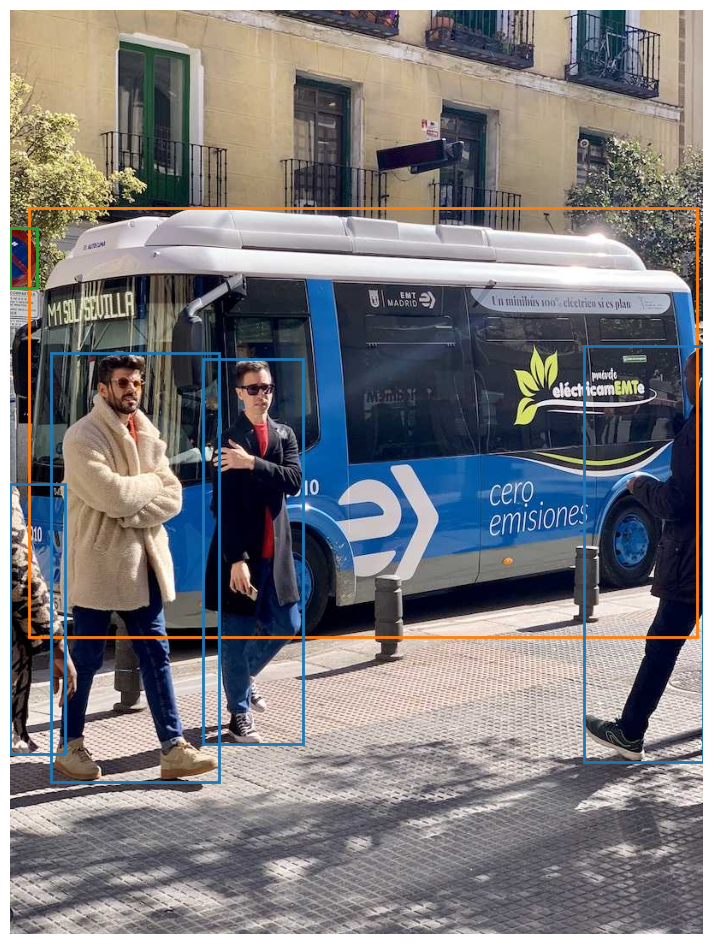

In [48]:
plot_boxes(image, new_boxes_object)